Name: Matthew Shedden

ID: 202068657

CS983: Evolutionary Computation for Finance I

# Portfolio Optimisation using Genetic Algorithms (R)
**About Genetic Algorithms**: An optimization and Machine Learning method that applies Neo-Darwinism evolutionary theory to perform an exhaustive search of all possible combinations. This is a fast method of optimisation as better solutions (and worse solutions) are used to create 'offspring' solutions.

**Genetic Algorithms in the context of Portfolio Optimisation, under Markowitz PT**: Briefly, [Markowitz Portfolio theory](https://www.investopedia.com/terms/m/modernportfoliotheory.asp) is a commonly-used method to generate optimal portfolio allocations, where 'Return' is maximised and 'Risk' is minimised.

**Project details**: We are going to using R and Genetic Algorithms to find the best possible weighting of a basket of stocks.

## 1 Selecting stocks
Stock price information is retreived from [Quantmod](https://cran.r-project.org/web/packages/quantmod/index.html) ([Quandl](https://www.quandl.com/) is an alternative). Stocks chosen are indicated in the following table alongside Ticker, [GICS sector](https://www.msci.com/gics), and Size* (denoted by [Yahoo Finance](https://finance.yahoo.com/screener)). Price information is captured for years' 2015-2020.

*Size: 5 stocks >= 10B ("large / mega cap"); 2B < 10B ("mid cap")

| Sector | Size | Company | Ticker |
| --- | --- | --- | --- |
| Basic Materials | Large / Mega | Barrick Gold | GOLD |
| Financial Services | Large / Mega | JP Morgan | JPM |
| Healthcare | Large / Mega | Bristol-Myers Squibb | BMY |
| Communication Services | Large / Mega | Verizon | VZ |
| Industrials | Large / Mega | MMM | MMM |
| Consumer Cyclical | Mid | Under Armor | UA |
| Consumer Defensive | Mid | COTY | COTY |
| Utilities | Mid | Enel Chile | ENIC |
| Energy | Mid | Marathon Oil | MRO |
| Technology | Mid | Dolby Laboratories | DLB |

In [1]:
#Setting global environment to hide warnings (this should be only used WHEN the code works 100% of the time)
options(warn=-1)
# Load universally useful packages: Tidyverse, Patchwork
library(tidyverse)
library(patchwork)
# Load packages for retreiving stock price information: Quantmod
library(quantmod)
# Load packages required for running a Genetic Algorithm
library(GA)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.0     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Loading required package: foreach

Attaching package: 'foreach'

The following objects are masked from 'package:purrr':

    accumulate, when

Loading required package: iterators
Package 'GA' version 3.2
Type 'citatio

To **test** the performance of Markowitz Portfolio Theory in practice, we shall download **two separate years** of data (train and test set, respectively).

In [2]:
# Retrieving 2018 data (training)
myStocks <- c("GOLD","JPM","BMY","VZ","MMM","UA","COTY","ENIC","MRO","DLB")
getSymbols(myStocks, src="yahoo", from="2018-01-01", to="2018-12-31")
RetData2018 <- data.frame(as.xts(merge(dailyReturn(GOLD), dailyReturn(JPM), dailyReturn(BMY),
                                       dailyReturn(VZ), dailyReturn(MMM), dailyReturn(UA),
                                       dailyReturn(COTY), dailyReturn(ENIC), dailyReturn(MRO), dailyReturn(DLB))))
# Retrieving 2019 data (testing)
getSymbols(myStocks, src="yahoo", from="2019-01-01", to="2019-12-31")
RetData2019 <- data.frame(as.xts(merge(dailyReturn(GOLD), dailyReturn(JPM), dailyReturn(BMY),
                                       dailyReturn(VZ), dailyReturn(MMM), dailyReturn(UA),
                                       dailyReturn(COTY), dailyReturn(ENIC), dailyReturn(MRO), dailyReturn(DLB))))
# Renaming columns
colnames(RetData2018) <- myStocks
colnames(RetData2019) <- myStocks

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.

pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols


[1] "GOLD" "JPM"  "BMY"  "VZ"   "MMM"  "UA"   "COTY" "ENIC" "MRO"  "DLB"

pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols


[1] "GOLD" "JPM"  "BMY"  "VZ"   "MMM"  "UA"   "COTY" "ENIC" "MRO"  "DLB"

In [3]:
# Calculate mean daily returns
MeanReturn2018 <- apply(RetData2018, MARGIN = 2, FUN = mean)
MeanReturn2019 <- apply(RetData2019, MARGIN = 2, FUN = mean)
# Calculate daily portfolio covariance
Covariance2018 <- cov(RetData2018)
Covariance2019 <- cov(RetData2019)
# Calculating cumulative returns
# 2018 data
CumRetData2018 <- cbind(Date = row.names(RetData2018), mutate(cumprod(1+RetData2018)))
CumRetData2018[,-1] <- CumRetData2018[,-1]-1
CumRetData2018$Date <- as.Date(CumRetData2018$Date)
# 2019 data
CumRetData2019 <- cbind(Date = row.names(RetData2019), mutate(cumprod(1+RetData2019)))
CumRetData2019[,-1] <- CumRetData2019[,-1]-1
CumRetData2019$Date <- as.Date(CumRetData2019$Date)

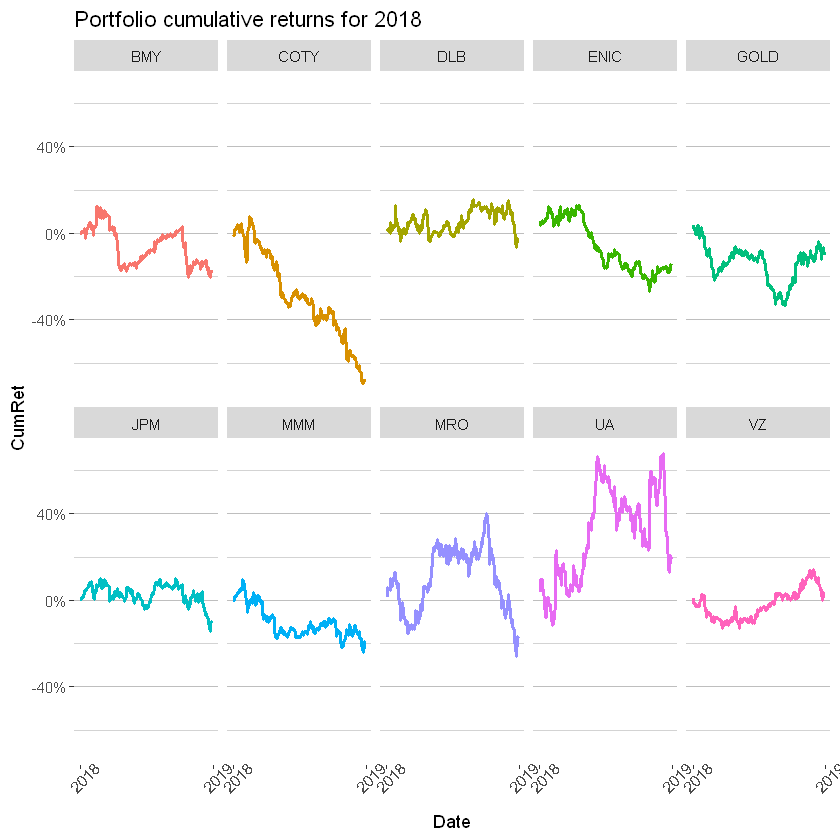

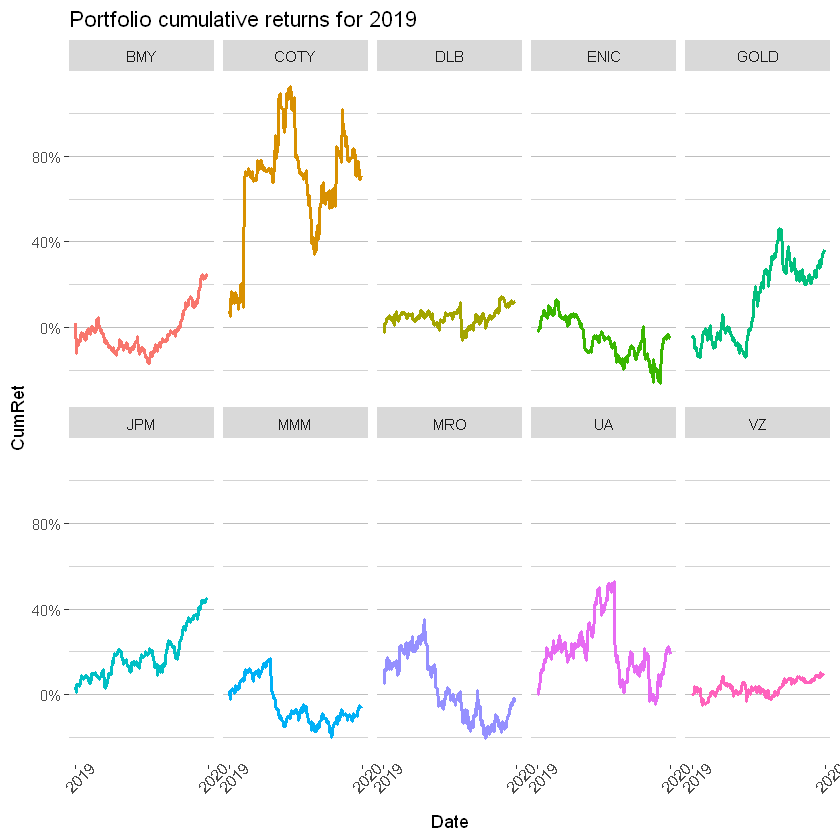

In [4]:
# Visualising cumulative returns of stocks
CumRetChart <- function(data, title){
    CumRetData <- pivot_longer(data = data, cols = -Date, names_to = 'Ticker', values_to = 'CumRet')
    ggplot(data = CumRetData) + geom_line(aes(x = Date, y = CumRet, colour = Ticker, group = Ticker), size = 1) +
    facet_wrap('Ticker', nrow = 2) +
    scale_x_date(date_breaks = "1 year", date_labels = '%Y') +
    scale_y_continuous(labels = scales::percent) +
    theme(legend.position = 'None', axis.text.x = element_text(angle = 45),
          panel.background = element_blank(), panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_line(colour = 'grey'), panel.grid.minor.y = element_line(colour = 'lightgrey')) +
    labs(title = title)
}

CumRetChart(CumRetData2018, 'Portfolio cumulative returns for 2018')
CumRetChart(CumRetData2019, 'Portfolio cumulative returns for 2019')

# 2 Using Genetic Algorithms to identify optimal weights

## 2.1 2018 portfolio returns

In [5]:
# Defining an initial 'random' weight
wt <- runif(n=length(myStocks))
# Defining the fitness function
OptimalWeight2018 <- function(wt){
  wt <- wt / sum(wt)                              # weight
  Return <- (sum(wt * MeanReturn2018)+1)^252-1    # returns
  Risk <- sqrt(t(wt) %*% (Covariance2018 %*% wt)) # risk
  Optimal <- Return / Risk                        # combination ('Sharpe ratio')
  return(Optimal)
}
# Building genetic algorithm
Optimizer2018 <- ga(type = "real-valued", fitness = OptimalWeight2018,
                    lower = rep(x = 0,times = length(myStocks)),
                    upper = rep(x = 1,times = length(myStocks)), maxiter = 1000, names = myStocks)
Optimizer2018@solution <- Optimizer2018@solution / sum(Optimizer2018@solution)

As is expected, the highest returning stock (UA) is paired with a stock with the lowest covariance (VZ) to return the optimal portfolio weighting, given returns for the year 2018.

## 2.2 2019 portfolio returns
To test the '2018 portfolio' against new data (2019 returns and risk), a new GA shall be first created. Then, 'weights' shall be compared; and the variation in returns and risk as weights change.

In [6]:
# Defining the fitness function
OptimalWeight2019 <- function(wt){
  wt <- wt / sum(wt)
  Return <- (sum(wt * MeanReturn2019)+1)^252-1
  Risk <- sqrt(t(wt) %*% (Covariance2019 %*% wt))
  Optimal <- Return / Risk
  return(Optimal)
}
# Genetic Algorithm
Optimizer2019 <- ga(type = "real-valued", fitness = OptimalWeight2019,
                    lower = rep(x = 0,times = length(myStocks)),
                    upper = rep(x = 1,times = length(myStocks)), maxiter = 1000,names = myStocks)
Optimizer2019@solution <- Optimizer2019@solution / sum(Optimizer2019@solution)

In [7]:
OptimizedPortfolios <- rbind(as.data.frame(Optimizer2018@solution), as.data.frame(Optimizer2019@solution))
OptimizedPortfolios$Year <- c('2018', '2019')

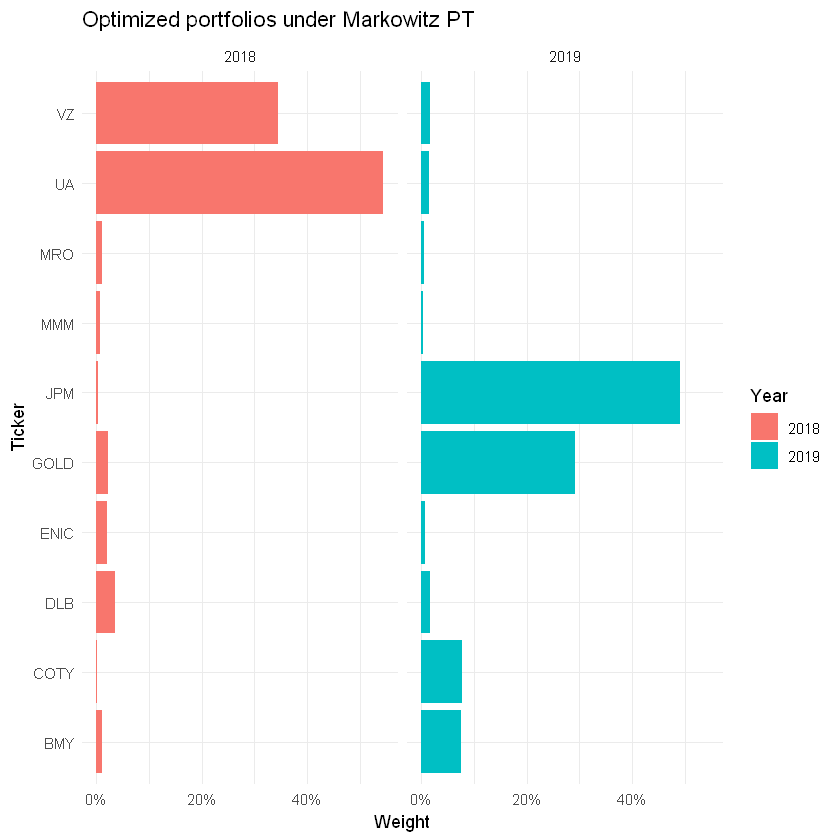

In [8]:
# visualise differences between the portfolio
pivot_longer(data = OptimizedPortfolios, cols = -Year, names_to = 'Ticker', values_to = 'Weight')  %>%
    ggplot() + geom_col(aes(y = Ticker, x = Weight, fill = Year)) + facet_wrap('Year') +
    scale_x_continuous(labels = scales::percent) + theme_minimal() +
    labs(title = 'Optimized portfolios under Markowitz PT')

# 3 Evaluating portfolios against random and optimized portfolios

In [9]:
weight_equal <- rep(x = 0.1,times = length(myStocks)) # equally weighted portfolio
weight_rand1 <- runif(n=length(myStocks)) 
weight_rand1 <- weight_rand1 / sum(weight_rand1)      # randomly weighted portfolio (1)
weight_rand2 <- runif(n=length(myStocks)) 
weight_rand2 <- weight_rand2 / sum(weight_rand2)      # randomly weighted portfolio (2)

cat("The evolved portfolio, for the 2018 (train) set, gives a return portfolio return of: ",
    round(((sum(Optimizer2018@solution * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe evolved portfolio, for the 2019 (test) set, gives a return portfolio return of: ",
    round(((sum(Optimizer2018@solution * MeanReturn2019)+1)^252-1)*100,digits = 2),"%",
    "\n\nThe equally weighted portfolio, for the 2018 (train) set, gives a return portfolio return of: ",
    round(((sum(weight_equal * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe equally weighted portfolio, for the 2019 (test) set, gives a return portfolio return of: ",
    round(((sum(weight_equal * MeanReturn2019)+1)^252-1)*100,digits = 2),"%",
    "\n\nThe 1st randomly weighted portfolio, for the 2018 (train) set, gives a return portfolio return of: ",
    round(((sum(weight_rand1 * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 1st randomly weighted portfolio, for the 2019 (test) set, gives a return portfolio return of: ",
    round(((sum(weight_rand1 * MeanReturn2019)+1)^252-1)*100,digits = 2),"%",
    "\n\nThe 2nd randomly weighted portfolio, for the 2018 (train) set, gives a return portfolio return of: ",
    round(((sum(weight_rand2 * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 2nd randomly weighted portfolio, for the 2019 (test) set, gives a return portfolio return of: ",
    round(((sum(weight_rand2 * MeanReturn2019)+1)^252-1)*100,digits = 2),"%")

The evolved portfolio, for the 2018 (train) set, gives a return portfolio return of:  19.6 % 
The evolved portfolio, for the 2019 (test) set, gives a return portfolio return of:  21.27 % 

The equally weighted portfolio, for the 2018 (train) set, gives a return portfolio return of:  -12.76 % 
The equally weighted portfolio, for the 2019 (test) set, gives a return portfolio return of:  24.57 % 

The 1st randomly weighted portfolio, for the 2018 (train) set, gives a return portfolio return of:  -4.45 % 
The 1st randomly weighted portfolio, for the 2019 (test) set, gives a return portfolio return of:  17.47 % 

The 2nd randomly weighted portfolio, for the 2018 (train) set, gives a return portfolio return of:  -8.68 % 
The 2nd randomly weighted portfolio, for the 2019 (test) set, gives a return portfolio return of:  27.04 %

Evaluating the performance of these random portfolios, the Optimised 2018 Portfolio is not the best performing portfolio on the test (2019) dataset! This makes one wonder the robustness of Markowitz portfolio optimisation, in practice.

## 4. Creation and evaluation of portfolios with differently balanced risk and return (to emulate a multi-objective approach)
Within the fitness functions presented, risk and return values will be evenly balanced. This can be modified to create differently balanced portfolios - e.g. at the extremes might be ones which only care about maximising returns or are very risk averse, and in between might be ones which prioritise risk over return and vice-versa.

In [10]:
# 1. Maximum return
MaximumReturn <- function(wt){
  wt <- wt / sum(wt)                                  # weight
  Return2018 <- (sum(wt * MeanReturn2018)+1)^252-1    # returns
  return(Return2018)
}
MaximumReturnOptimizer <- ga(type = "real-valued", fitness = MaximumReturn,
                             lower = rep(x = 0,times = length(myStocks)),
                             upper = rep(x = 1,times = length(myStocks)), maxiter = 1000, names = myStocks, monitor = F)
MaximumReturnOptimizer@solution <- MaximumReturnOptimizer@solution / sum(MaximumReturnOptimizer@solution)
colnames(MaximumReturnOptimizer@solution) <- myStocks
cat("The weighting of the 'Maximum Return' portfolio is: ", MaximumReturnOptimizer@solution)

The weighting of the 'Maximum Return' portfolio is:  0.008182235 0.05032755 0.02604702 0.03100394 0.02379811 0.822259 0.007346475 0.01557261 0.003689904 0.01177321

In [11]:
# 2. Minimum risk
MinimumRisk <- function(wt){
  wt <- wt / sum(wt)                                  # weight
  Risk2018 <- sqrt(t(wt) %*% (Covariance2018 %*% wt)) # risk
  return(-Risk2018)                                   # '-' required for minimization problem
}
MinimumRiskOptimizer <- ga(type = "real-valued", fitness = MinimumRisk,
                           lower = rep(x = 0,times = length(myStocks)),
                           upper = rep(x = 1,times = length(myStocks)), maxiter = 1000, names = myStocks, monitor = F)
MinimumRiskOptimizer@solution <- MinimumRiskOptimizer@solution / sum(MinimumRiskOptimizer@solution)
colnames(MinimumRiskOptimizer@solution) <- myStocks
cat("The optimal weighting of the 'Minimum Risk' portfolio is: ", MinimumRiskOptimizer@solution)

The optimal weighting of the 'Minimum Risk' portfolio is:  0.1673997 0.1392809 0.1091254 0.2974529 0.007600579 0.001713965 0.03792936 0.09310462 0.00435706 0.1420356

In [12]:
# 3. 'Adventurous' (75:25 weighting)
Adventurous <- function(wt){
  wt <- wt / sum(wt)                                                    # weight
  Return2018 <- (sum((wt*(75/25)) * MeanReturn2018)+1)^252-1            # greater returns
  Risk2018 <- sqrt(t(wt*(75/25)) %*% (Covariance2018 %*% (wt*(75/25)))) # greater risk
  Optimal2018 <- (Return2018 / Risk2018)                                # combination ('Sharpe ratio')
  return(Optimal2018)
}
AdventurousOptimizer <- ga(type = "real-valued", fitness = Adventurous,
                           lower = rep(x = 0,times = length(myStocks)),
                           upper = rep(x = 1,times = length(myStocks)), maxiter = 1000, names = myStocks, monitor = F)
AdventurousOptimizer@solution <- AdventurousOptimizer@solution / sum(AdventurousOptimizer@solution)
colnames(AdventurousOptimizer@solution) <- myStocks
cat("The optimal weighting of the 'Adventurous' portfolio is: ", AdventurousOptimizer@solution)

The optimal weighting of the 'Adventurous' portfolio is:  0.005151885 0.009261537 0.008968388 0.1089399 0.008821911 0.784126 0.0102307 0.01516346 0.03170104 0.01763516

In [13]:
# 4. 'Cautious' (25:75 weighting)
Cautious <- function(wt){
  wt <- wt / sum(wt)                                                    # weight
  Return2018 <- (sum((wt*(25/75)) * MeanReturn2018)+1)^252-1            # less returns
  Risk2018 <- sqrt(t(wt*(25/75)) %*% (Covariance2018 %*% (wt*(25/75)))) # less risk
  Optimal2018 <- (Return2018 / Risk2018)                                # combination ('Sharpe ratio')
  return(Optimal2018)
}
CautiousOptimizer <- ga(type = "real-valued", fitness = Cautious,
                        lower = rep(x = 0,times = length(myStocks)), 
                        upper = rep(x = 1,times = length(myStocks)), maxiter = 1000, names = myStocks, monitor = F)
CautiousOptimizer@solution <- CautiousOptimizer@solution / sum(CautiousOptimizer@solution)
colnames(CautiousOptimizer@solution) <- myStocks
cat("The optimal weighting of the 'Cautious' portfolio is: ", CautiousOptimizer@solution)

The optimal weighting of the 'Cautious' portfolio is:  0.007297523 0.02873834 0.01389894 0.4275236 0.01051892 0.4834116 0.001557222 0.005846442 0.0008088652 0.02039858

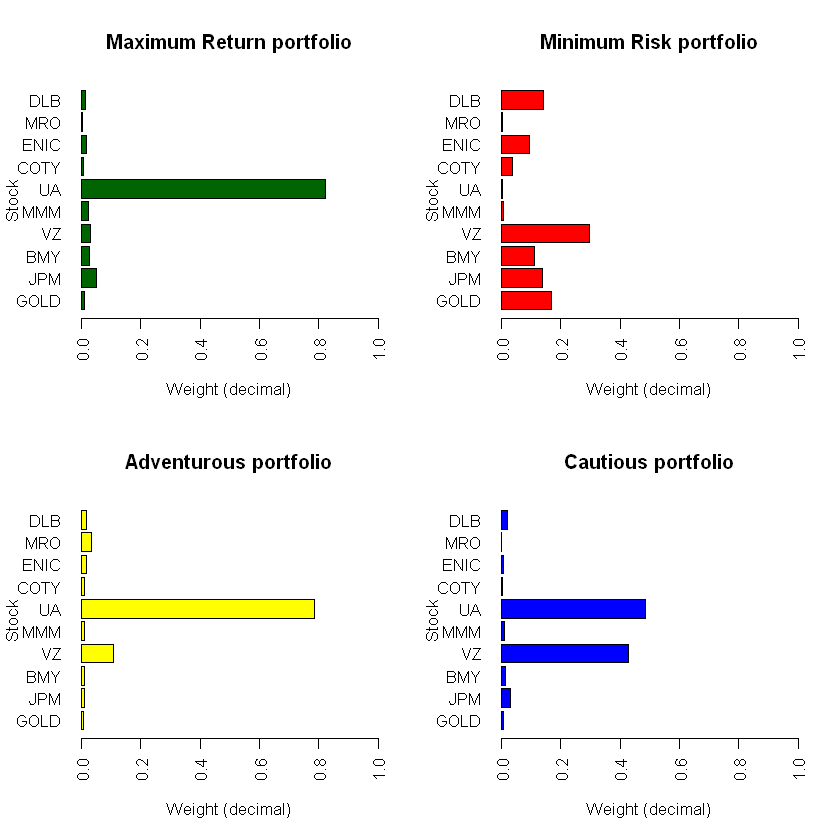

In [14]:
par(mfrow = c(2,2))

barplot(MaximumReturnOptimizer@solution,col="darkgreen", horiz = T, xlim = c(0,1), las = 2,
        xlab = "Weight (decimal)", ylab = "Stock", main="Maximum Return portfolio") 
barplot(MinimumRiskOptimizer@solution,col="red", horiz = T, xlim = c(0,1), las = 2, 
        xlab = "Weight (decimal)", ylab = "Stock", main="Minimum Risk portfolio")
barplot(AdventurousOptimizer@solution,col="yellow", horiz = T, xlim = c(0,1), las = 2,
        xlab = "Weight (decimal)", ylab = "Stock", main="Adventurous portfolio") 
barplot(CautiousOptimizer@solution,col="blue", horiz = T, xlim = c(0,1), las = 2,
        xlab = "Weight (decimal)", ylab = "Stock", main="Cautious portfolio")

In [15]:
cat("The 'Maximum Return' portfolio, for the 2018 (train) set, gives a return of: ",
    round(((sum(MaximumReturnOptimizer@solution * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 'Maximum Return' portfolio, for the 2018 (train) set, gives a st.dev of: ",
    round(sqrt(t(as.numeric(MaximumReturnOptimizer@solution[1,])) %*%
               (Covariance2018 %*% as.numeric(MaximumReturnOptimizer@solution[1,]))),2),
    "\n\nThe 'Minimum Risk' portfolio, for the 2018 (train) set, gives a return of: ",
    round(((sum(MinimumRiskOptimizer@solution * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 'Minimum Risk' portfolio, for the 2018 (train) set, gives a st.dev of: ",
    round(sqrt(t(as.numeric(MinimumRiskOptimizer@solution[1,])) %*%
               (Covariance2018 %*% as.numeric(MinimumRiskOptimizer@solution[1,]))),2),
    "\n\nThe 'Adventurous' portfolio, for the 2018 (train) set, gives a return of: ",
    round(((sum(AdventurousOptimizer@solution * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 'Adventurous' portfolio, for the 2018 (train) set, gives a st.dev of: ",
    round(sqrt(t(as.numeric(AdventurousOptimizer@solution[1,])) %*%
               (Covariance2018 %*% as.numeric(AdventurousOptimizer@solution[1,]))),2),
    "\n\nThe 'Cautious' portfolio, for the 2018 (train) set, gives a return of: ",
    round(((sum(CautiousOptimizer@solution * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 'Cautious' portfolio, for the 2018 (train) set, gives a st.dev of: ",
    round(sqrt(t(as.numeric(CautiousOptimizer@solution[1,])) %*% 
               (Covariance2018 %*% as.numeric(CautiousOptimizer@solution[1,]))),2))

The 'Maximum Return' portfolio, for the 2018 (train) set, gives a return of:  26.06 % 
The 'Maximum Return' portfolio, for the 2018 (train) set, gives a st.dev of:  0.03 

The 'Minimum Risk' portfolio, for the 2018 (train) set, gives a return of:  -6.88 % 
The 'Minimum Risk' portfolio, for the 2018 (train) set, gives a st.dev of:  0.01 

The 'Adventurous' portfolio, for the 2018 (train) set, gives a return of:  25.6 % 
The 'Adventurous' portfolio, for the 2018 (train) set, gives a st.dev of:  0.03 

The 'Cautious' portfolio, for the 2018 (train) set, gives a return of:  17.94 % 
The 'Cautious' portfolio, for the 2018 (train) set, gives a st.dev of:  0.02

Clear differences persist in risk / return when maximising return or minimising risk.